In [4]:
!pip3 install -r rqts.txt

# conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch
# conda create --name dl_7 python=3.7

# torch==1.11.0
# torchvision==0.12.0
# cudatoolkit=11.3

  Using cached pycocotools_windows-2.0.0.2-cp37-cp37m-win_amd64.whl (83 kB)
  Using cached Cython-0.29.28-py2.py3-none-any.whl (983 kB)
  Using cached matplotlib-3.5.2-cp37-cp37m-win_amd64.whl (7.2 MB)
  Using cached kiwisolver-1.4.2-cp37-cp37m-win_amd64.whl (54 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.33.3-py3-none-any.whl (930 kB)


In [5]:
import sys
sys.version


'3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]'

In [6]:
import torch
torch.__version__

'1.11.0'

In [7]:
import downloader
# downloader.get_custom_drinks_dataset()
downloader.get_drinks_dataset()


Directory: data\ - exists
File: 		data\drinks.tar.gz
File Size:	146820533
Data Set Already Downloaded
Drinks Folder Already Exists


True

In [8]:
import os
# import label_utils
import dataload
data_dir = 'data'
test_csv_path = os.path.join(data_dir, 'drinks', 'labels_test.csv')
# test_dict, test_classes = label_utils.build_label_dictionary(test_csv_path)
test_dict, test_classes = dataload.get_dataset_dict(train=False)

test_csv_path = os.path.join(data_dir, 'drinks', 'labels_train.csv')
train_dict, train_classes = dataload.get_dataset_dict(train=True)

keylist = []
for key, val in train_dict.items():
	# print(len(val['masks']))
	if len(val['masks']) ==0:
		print(key)
		keylist.append(key)
# del train_dict[key]
print(keylist)
for key in keylist:
	del train_dict[key]

# test_seg_dict, test_seg_classes =
# train_dict['data\\drinks\\0000990.jpg']

Total Unique Masks 3
Unique Masks ['1', '2', '3']
Total Unique Masks 3
Unique Masks ['3', '1', '2']
data\drinks\0000352.jpg
data\drinks\0000552.jpg
data\drinks\0000990.jpg
['data\\drinks\\0000352.jpg', 'data\\drinks\\0000552.jpg', 'data\\drinks\\0000990.jpg']


In [8]:
import numpy as np
import os
from PIL import Image, ImageDraw

dp = os.path.join('data', 'drinks_imgs')
downloader.check_create_directory(dpath=dp)

dp = os.path.join('data', 'drinks_masks')
downloader.check_create_directory(dpath=dp)


for key, val in train_dict.items():
	print(key, val)
	masks = val['masks']

	img_path = val['filename']
	img = Image.open(img_path).convert("RGB")

	imfp = os.path.join('data', 'drinks_imgs')
	imfp = img_path.replace(os.path.join('data','drinks'), imfp)
	print(imfp)
	img.save(imfp)

	mask_list = []
	for mask in masks:
		
		name = mask['Name']
		num = int(name)

		xl = mask['x']
		yl = mask['y']
		poly = [(xc,yc) for xc,yc in zip(xl,yl)]
		poly


		img2 = Image.new('L', img.size, 0)
		img3 = ImageDraw.Draw(img2).polygon(poly, outline=num, fill=num)
		mask_im = np.array(img2)
		mask_list.append(mask_im)
		# display(img3)
	# mask_list = np.concatenate(mask_list, axis=0 )

	# mask_list = np.dstack(mask_list)
	# mask_list = mask_list.max(axis = 2)

	mask_list = np.maximum.reduce(mask_list)

	print('\n\n', np.unique(mask_list))
	print(mask_list.shape)

	
	im = Image.fromarray(mask_list)

	imfp = os.path.join('data', 'drinks_masks')
	imfp = img_path.replace(os.path.join('data','drinks'), imfp)
	imfp = imfp.replace('.jpg', '.png')
	print(imfp)

	im.save(imfp)
	
	print(im)
	# input()


ImportError: cannot import name 'Image' from 'PIL' (unknown location)

In [9]:
# # mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# mask = Image.open('data/drinks_masks/0000005.png')
# # each mask instance has a different color, from zero to N, where
# # N is the number of instances. In order to make visualization easier,
# # let's adda color palette to the mask.
# mask.putpalette([
#     0, 0, 0, # black background
#     255, 0, 0, # index 1 is red
#     255, 255, 0, # index 2 is yellow
#     255, 153, 0, # index 3 is orange
# ])
# mask

In [10]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "drinks_imgs"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "drinks_masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "drinks_imgs", self.imgs[idx])
        mask_path = os.path.join(self.root, "drinks_masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # print('unique ids', obj_ids)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # print('masks:', masks)
        # print('masks:', masks.ndim)

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [12]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [14]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('data', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions



In [15]:

indices = torch.randperm(len(dataset)).tolist()
indices

[611,
 261,
 578,
 870,
 450,
 745,
 774,
 482,
 213,
 640,
 612,
 298,
 85,
 192,
 994,
 970,
 307,
 180,
 844,
 643,
 809,
 590,
 222,
 155,
 835,
 443,
 661,
 765,
 559,
 770,
 854,
 184,
 301,
 914,
 6,
 453,
 457,
 435,
 514,
 845,
 286,
 797,
 981,
 520,
 614,
 382,
 707,
 697,
 868,
 971,
 106,
 638,
 432,
 724,
 934,
 764,
 118,
 5,
 169,
 299,
 664,
 632,
 333,
 606,
 132,
 113,
 200,
 964,
 542,
 448,
 504,
 95,
 700,
 309,
 145,
 164,
 569,
 35,
 570,
 411,
 484,
 345,
 893,
 827,
 575,
 871,
 743,
 551,
 600,
 83,
 824,
 310,
 101,
 758,
 290,
 215,
 316,
 537,
 315,
 852,
 308,
 855,
 193,
 133,
 470,
 2,
 421,
 171,
 703,
 730,
 321,
 228,
 906,
 686,
 808,
 663,
 927,
 609,
 266,
 892,
 387,
 373,
 428,
 839,
 60,
 996,
 759,
 649,
 412,
 767,
 591,
 903,
 880,
 399,
 866,
 720,
 211,
 123,
 80,
 231,
 963,
 210,
 962,
 641,
 10,
 741,
 635,
 804,
 281,
 260,
 540,
 922,
 517,
 930,
 603,
 518,
 617,
 397,
 776,
 768,
 474,
 862,
 621,
 753,
 236,
 932,
 460,
 22,
 485,


In [20]:
# use our dataset and defined transformations
dataset = PennFudanDataset('data', get_transform(train=True))
dataset_test = PennFudanDataset('data', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [22]:
device


device(type='cuda')

In [24]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/237]  eta: 0:03:51  lr: 0.000026  loss: 0.2316 (0.2316)  loss_classifier: 0.0412 (0.0412)  loss_box_reg: 0.0705 (0.0705)  loss_mask: 0.1174 (0.1174)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 0.9751  data: 0.0460  max mem: 6090


KeyboardInterrupt: 

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
model.load_state_dict(torch.load('drinks_model_santiago.pth'))
# move model to the right device
model.to(device)

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:14  model_time: 0.2842 (0.2842)  evaluator_time: 0.0040 (0.0040)  time: 0.2992  data: 0.0100  max mem: 6091
Test:  [49/50]  eta: 0:00:00  model_time: 0.0820 (0.0886)  evaluator_time: 0.0040 (0.0037)  time: 0.0970  data: 0.0097  max mem: 6091
Test: Total time: 0:00:05 (0.1029 s / it)
Averaged stats: model_time: 0.0820 (0.0886)  evaluator_time: 0.0040 (0.0037)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.923
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma

In [ ]:

evaluate(model, data_loader_test, device=device)

In [ ]:
# torch.save(model.state_dict(), "drinks_model_santiago.pth")

In [28]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [29]:
prediction


[{'boxes': tensor([[277.9869, 135.7787, 342.3912, 294.4194],
          [102.1810,  68.5758, 195.6354, 301.3925],
          [362.4102, 150.6094, 430.5232, 285.1916]], device='cuda:0'),
  'labels': tensor([1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9998, 0.9996, 0.9995], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ...,

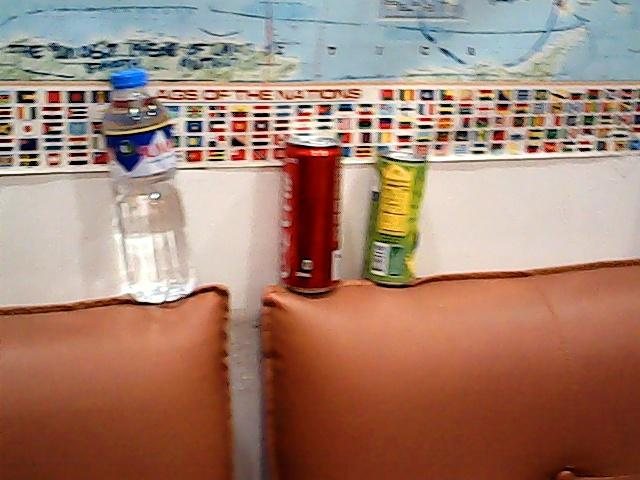

In [30]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

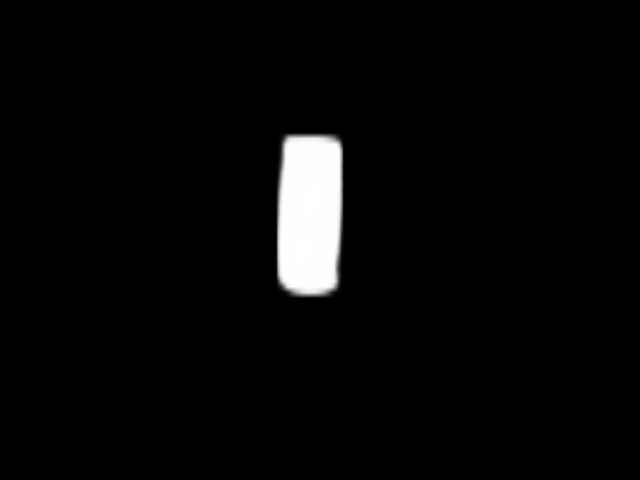

In [31]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())